# Load data and preprocess #

### This code is for loading the data from kaggle, performing any necessary transformations, and storing the modified results in a .csv file for easier access ###

In [1]:
# Automatically load changes in dependency files (may be unnecessary here, but useful tool in case you're modifying packages that this file relies on)
%load_ext autoreload
%autoreload 2

## First need to download the dataset from Kaggle ##
I moved the dataset to a local directory for better access to it, since the default installed in .cache/kagglehub

In [2]:

# %conda install kagglehub
import kagglehub

# May have to install transformers and gensim for tokenization later, uncomment if needed
# !pip install gensim
# !pip isntall transformers

# Download latest version
path = kagglehub.dataset_download("goyaladi/twitter-bot-detection-dataset")

print("Path to dataset files:", path)

c:\Users\maden\anaconda3\envs\COSC325\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\maden\.cache\kagglehub\datasets\goyaladi\twitter-bot-detection-dataset\versions\2


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler


import os

In [4]:
# Recursive find for bot data from current directory
path = None
for dirpath, dirnames, filenames in os.walk("."):
    for filename in filenames:
        if filename == "bot_detection_data.csv":
            path = os.path.join(dirpath, filename)

assert path is not None, "bot_detection_data.csv not found in current directory or any subdirectories"
print(f"Path to csv file: {path}")

Path to csv file: .\data\bot_detection_data.csv


In [5]:
# Read in data into dataframe and get some preliminary information about dataset
df = pd.read_csv(path)

print(df.dtypes)

df.head()

User ID            int64
Username          object
Tweet             object
Retweet Count      int64
Mention Count      int64
Follower Count     int64
Verified            bool
Bot Label          int64
Location          object
Created At        object
Hashtags          object
dtype: object


,User ID,Username,Tweet,Retweet Count,Mention Count,Follower Count,Verified,Bot Label,Location,Created At,Hashtags
0,132131,flong,Station activity person against natural majori...,85,1,2353,False,1,Adkinston,2020-05-11 15:29:50,NaN
1,289683,hinesstephanie,Authority research natural life material staff...,55,5,9617,True,0,Sanderston,2022-11-26 05:18:10,both live
2,779715,roberttran,Manage whose quickly especially foot none to g...,6,2,4363,True,0,Harrisonfurt,2022-08-08 03:16:54,phone ahead
3,696168,pmason,Just cover eight opportunity strong policy which.,54,5,2242,True,1,Martinezberg,2021-08-14 22:27:05,ever quickly new I
4,704441,noah87,Animal sign six data good or.,26,3,8438,False,1,Camachoville,2020-04-13 21:24:21,foreign mention


In [6]:
# An issue right off the bat, created at should be Unix epoch time. Convert to datetime, then to int 
df["Created At"] = pd.to_datetime(df["Created At"]).astype("int64") // 10**9 # Convert to seconds
df["Location"] = df["Location"].astype(str)
df["Hashtags"] = df["Hashtags"].astype(str)

print(df.dtypes)

User ID            int64
Username          object
Tweet             object
Retweet Count      int64
Mention Count      int64
Follower Count     int64
Verified            bool
Bot Label          int64
Location          object
Created At         int64
Hashtags          object
dtype: object


In [7]:
# Check for NaN values in the dataset
print(df.isna().sum())

User ID           0
Username          0
Tweet             0
Retweet Count     0
Mention Count     0
Follower Count    0
Verified          0
Bot Label         0
Location          0
Created At        0
Hashtags          0
dtype: int64


In [8]:
'''
Looks like data is already fairly clean, the only NaN column is hashtags
We want our model to generalize, so it should not include the User ID or Username as parameters
The bot label will need to be dropped before feeding data to the model.
'''

df = df.drop(["User ID", "Username"], axis=1)
df.head()

,Tweet,Retweet Count,Mention Count,Follower Count,Verified,Bot Label,Location,Created At,Hashtags
0,Station activity person against natural majori...,85,1,2353,False,1,Adkinston,1589210990,nan
1,Authority research natural life material staff...,55,5,9617,True,0,Sanderston,1669439890,both live
2,Manage whose quickly especially foot none to g...,6,2,4363,True,0,Harrisonfurt,1659928614,phone ahead
3,Just cover eight opportunity strong policy which.,54,5,2242,True,1,Martinezberg,1628980025,ever quickly new I
4,Animal sign six data good or.,26,3,8438,False,1,Camachoville,1586813061,foreign mention


In [9]:
'''Our biggest problem now is the string labels - they can't be one-hot-encoded, so we will need to tokenize them.
First, create lists of the items, since Tfidf vectorizer requires an iterable.
This works for hashtags and tweets, but not locations - we will have to one-hot encode those.
'''

txt_data = df["Tweet"] + ' ' + df["Hashtags"]

In [10]:
''' Initialize vectorizer and fit

 Also this site helped me understand how to use this library and what it does:
 https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/
 '''
vectorizer = TfidfVectorizer()

txt_data_matrix = vectorizer.fit_transform(txt_data)

print(txt_data_matrix[0])

# More interesting case -- a lot of these which are only one word long have a score of 1.0
print(txt_data_matrix[1])


  (0, 799)	0.2835294682766055
  (0, 10)	0.28377526964993016
  (0, 605)	0.2854437101326405
  (0, 20)	0.2861260608232863
  (0, 530)	0.28336623111754666
  (0, 473)	0.2851900744232126
  (0, 545)	0.2826378164501514
  (0, 292)	0.28707885767072966
  (0, 761)	0.28903737666080176
  (0, 275)	0.28967601591872344
  (0, 760)	0.2856985642728896
  (0, 481)	0.28427031555777604
  (0, 527)	0.14805443620650166
  (0, 530)	0.2863499012090043
  (0, 69)	0.2868462995680757
  (0, 692)	0.29010161940964224
  (0, 452)	0.28709623307322024
  (0, 482)	0.28759962306049996
  (0, 791)	0.2896618249846389
  (0, 664)	0.28709623307322024
  (0, 166)	0.2894869124648654
  (0, 648)	0.2865975258513498
  (0, 65)	0.2938508641068884
  (0, 108)	0.2899252684619582
  (0, 460)	0.2893996697446291


In [11]:
''' The support vector machine will expect lists of fixed size. Currently, 
values are stored in a dense matrix, since most entries in the vocabulary are 0. 
We'll drop these columns from the DataFrame and work on preprocessing the rest of the data
'''

# Save columns first if we need to add them back later (BERT Encoding)
twt_col = df["Tweet"]
hashtag_col = df["Hashtags"]

df = df.drop(['Tweet', 'Hashtags'], axis=1)

txt_data_matrix = txt_data_matrix.astype('float64')

In [12]:
# Now need to one-hot encode location
label_encoder = LabelEncoder()

'''Print the length of Location before. We can see that some locations are repeated,
 but there are still 25k unique values. Some more preprocessing may be necessary here.

'''
print(f"{len(df['Location'])}")

df["Location"] = label_encoder.fit_transform(df["Location"])

df["Location"].unique()

50000


array([   85, 19263,  6482, ..., 23730,  9388,  2938])

Text(0.5, 1.0, 'Collinearity of Features')

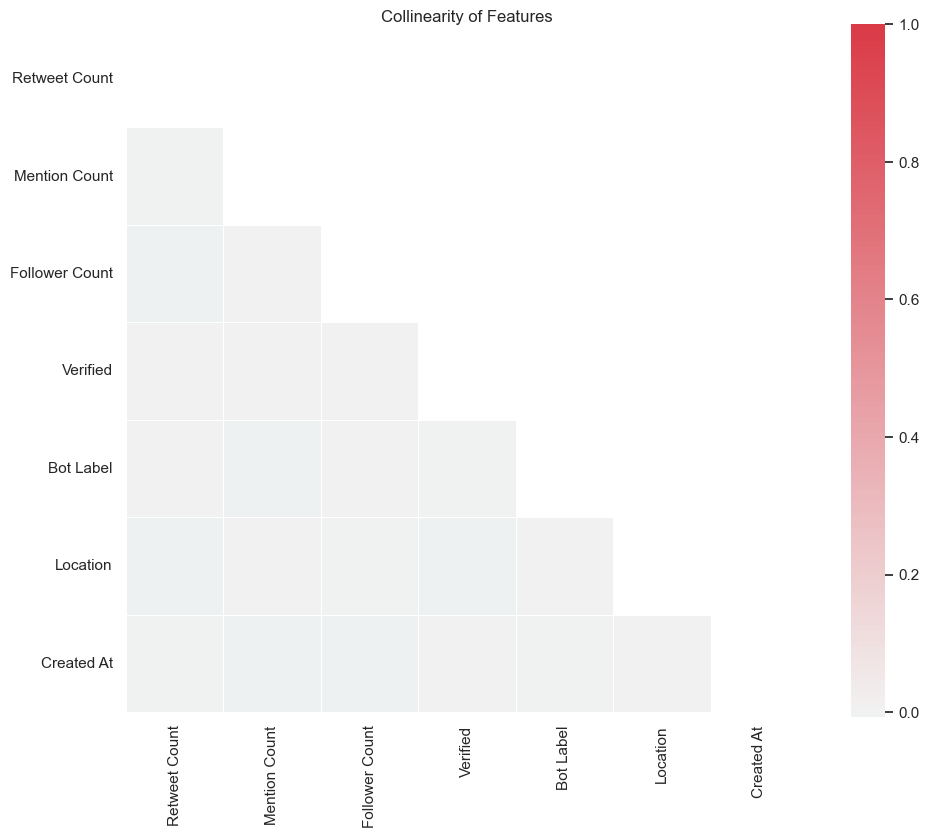

In [13]:
# Next, we check for collinearity among these features
# Source: https://medium.com/5-minute-eda/5-minute-eda-correlation-heatmap-b57bbb7bae14#:~:text=A%20correlation%20heatmap%20is%20a,1%20signifies%20a%20perfect%20correlation.
sns.set_theme(style="white")
corr = df.corr()
mask = np.zeros_like(corr, dtype=bool) # Array of 0s with same size and dtype as corr
mask[np.triu_indices_from(mask)] = True # Upper triangle set to True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidth=.5)
ax.set_title("Collinearity of Features")

In [14]:
# Normalize values in DataFrame
scaler = MinMaxScaler()

cols_to_scale = ["Retweet Count", "Mention Count", "Follower Count", "Location", "Created At"]

for col in cols_to_scale:
    df[col] = scaler.fit_transform(df[[col]])

In [15]:
# Combine our text data with df
df_columns = df.columns.tolist()

txt_cols = []
for i in range(1, 971):
    txt_cols.append(f"w{i}")

df_columns.extend(txt_cols)
df = df.to_numpy().astype('float64')

# Convert to dense matrix for stacking
txt_data_matrix = txt_data_matrix.toarray()
print(f"txt_data_matrix.shape: {txt_data_matrix.shape}")
print(f"df.shape: {df.shape}")
combined_data = np.hstack((df, txt_data_matrix))

# Convert back to DataFrame for storage
df = pd.DataFrame(combined_data, columns=df_columns)
df.head()

txt_data_matrix.shape: (50000, 970)
df.shape: (50000, 7)


,Retweet Count,Mention Count,Follower Count,Verified,Bot Label,Location,Created At,w1,w2,w3,...,w961,w962,w963,w964,w965,w966,w967,w968,w969,w970
0,0.85,0.2,0.2353,0.0,1.0,0.003373,0.105605,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.55,1.0,0.9617,1.0,0.0,0.764465,0.850671,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.06,0.4,0.4363,1.0,0.0,0.257243,0.762343,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.54,1.0,0.2242,1.0,1.0,0.432733,0.474930,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.26,0.6,0.8438,0.0,1.0,0.067188,0.083336,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# Most features don't seem highly correlated, so no need to drop any (no risk here of overprioritizing certain aspects of dataset)

# Save dataset to csv file

#df.to_csv('data/preprocessed_data.csv', index=True)

# Try parquet, it is allegedly faster and will preserve data types (namely, the lists)
df.to_parquet('data/preprocessed_data.parquet')

In [17]:
# That data did not seem to work well. Using BERT or Word2Vec, we will revisit the embedding of textual data
from transformers import BertTokenizer, BertConfig

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Example of how it works
text = "the quick brown fox jumps over the lazy dog"
tokens = tokenizer.tokenize(text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print("Tokens: ", tokens)
print("Token ids: ", token_ids)

# We'll use this one since it adds special tokens like [SEP]
tokens = tokenizer.encode(text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print("Encoded: ", tokens)


None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


Tokens:  ['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']
Token ids:  [1996, 4248, 2829, 4419, 14523, 2058, 1996, 13971, 3899]
Encoded:  [101, 1996, 4248, 2829, 4419, 14523, 2058, 1996, 13971, 3899, 102]


In [18]:
# Restrict columns to all except for text data
df = df[["Retweet Count", "Mention Count", "Follower Count", "Verified", "Bot Label", "Location", "Created At"]]

df = pd.concat([df, twt_col, hashtag_col], axis=1)

df.head()

,Retweet Count,Mention Count,Follower Count,Verified,Bot Label,Location,Created At,Tweet,Hashtags
0,0.85,0.2,0.2353,0.0,1.0,0.003373,0.105605,Station activity person against natural majori...,nan
1,0.55,1.0,0.9617,1.0,0.0,0.764465,0.850671,Authority research natural life material staff...,both live
2,0.06,0.4,0.4363,1.0,0.0,0.257243,0.762343,Manage whose quickly especially foot none to g...,phone ahead
3,0.54,1.0,0.2242,1.0,1.0,0.432733,0.474930,Just cover eight opportunity strong policy which.,ever quickly new I
4,0.26,0.6,0.8438,0.0,1.0,0.067188,0.083336,Animal sign six data good or.,foreign mention


In [19]:
# After tokenization, use Word2Vec to embed words: https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.html
# Padding to make it easier when flattening out into columns
encoded_twt = tokenizer(df["Tweet"].tolist(), padding=True)
df["Tweet"] = encoded_twt["input_ids"]

encoded_hashtags = tokenizer(df["Hashtags"].tolist(), padding=True)
df["Hashtags"] = encoded_hashtags["input_ids"]

import gensim
from gensim.models import Word2Vec

def get_sentence_embedding(tokens, model):
    valid_tokens = [token for token in tokens if token in model.wv]
    if not valid_tokens:
        return np.zeros(model.vector_size)
    
    # Return mean for embedding of the sentence
    return np.mean(model.wv[valid_tokens], axis=0)


twt_model = Word2Vec(encoded_twt["input_ids"], min_count=1, vector_size=100, seed=42, workers=4)
hashtag_model = Word2Vec(encoded_hashtags["input_ids"], min_count=1, vector_size=100, seed=42, workers=4)

df["Tweet"] = df["Tweet"].apply(lambda tokens: get_sentence_embedding(tokens, twt_model))
df["Hashtags"] = df["Hashtags"].apply(lambda tokens: get_sentence_embedding(tokens, hashtag_model))

df.head()

,Retweet Count,Mention Count,Follower Count,Verified,Bot Label,Location,Created At,Tweet,Hashtags
0,0.85,0.2,0.2353,0.0,1.0,0.003373,0.105605,"[0.58442277, -0.44875756, 0.22199216, -0.08359...","[-0.35002995, -0.16879569, 0.1357387, -0.02084..."
1,0.55,1.0,0.9617,1.0,0.0,0.764465,0.850671,"[0.6030587, -0.5392003, 0.2610763, -0.05339244...","[-0.20993058, -0.30967736, 0.22648755, -0.0622..."
2,0.06,0.4,0.4363,1.0,0.0,0.257243,0.762343,"[0.6021777, -0.5444441, 0.25941738, -0.0580339...","[-0.20259608, -0.31819913, 0.22690043, -0.0617..."
3,0.54,1.0,0.2242,1.0,1.0,0.432733,0.474930,"[0.62992066, -0.66145974, 0.31215787, -0.02632...","[-0.05733835, -0.35614485, 0.2676731, -0.04486..."
4,0.26,0.6,0.8438,0.0,1.0,0.067188,0.083336,"[0.6314546, -0.7026064, 0.3262894, -0.01022859...","[-0.20172688, -0.30911303, 0.21654083, -0.0558..."


In [20]:
df["Hashtags"].head()

0    [-0.35002995, -0.16879569, 0.1357387, -0.02084...
1    [-0.20993058, -0.30967736, 0.22648755, -0.0622...
2    [-0.20259608, -0.31819913, 0.22690043, -0.0617...
3    [-0.05733835, -0.35614485, 0.2676731, -0.04486...
4    [-0.20172688, -0.30911303, 0.21654083, -0.0558...
Name: Hashtags, dtype: object

In [21]:
# Padding looks correct, now flatten out into columns
col_names = df.columns[:-2].tolist()

# The text data all has the same length, so we can flatten them
for i in range(1, len(df["Tweet"].iloc[0])+1):
    col_names.append(f"twt_{i}")

for i in range(1, len(df["Hashtags"].iloc[0])+1):
    col_names.append(f"hashtag_{i}")

twt_col = np.vstack(df["Tweet"].values)
hashtag_col = np.vstack(df["Hashtags"].values)
df = df.drop(["Tweet", "Hashtags"], axis=1)

df = np.array(df)
twt_col = np.array(twt_col)
hashtag_col = np.array(hashtag_col)

df = np.hstack((df, twt_col, hashtag_col))

df = pd.DataFrame(df, columns=col_names)
df.head()

,Retweet Count,Mention Count,Follower Count,Verified,Bot Label,Location,Created At,twt_1,twt_2,twt_3,...,hashtag_91,hashtag_92,hashtag_93,hashtag_94,hashtag_95,hashtag_96,hashtag_97,hashtag_98,hashtag_99,hashtag_100
0,0.85,0.2,0.2353,0.0,1.0,0.003373,0.105605,0.584423,-0.448758,0.221992,...,0.125355,0.294862,0.243294,-0.232206,0.374747,-0.269184,-0.382470,0.024018,0.018229,0.061237
1,0.55,1.0,0.9617,1.0,0.0,0.764465,0.850671,0.603059,-0.539200,0.261076,...,-0.117175,0.335634,0.013350,-0.247745,0.262996,-0.240250,-0.224535,0.108484,-0.118404,0.086830
2,0.06,0.4,0.4363,1.0,0.0,0.257243,0.762343,0.602178,-0.544444,0.259417,...,-0.124059,0.338809,0.000209,-0.249944,0.263091,-0.238794,-0.226714,0.108327,-0.122253,0.091454
3,0.54,1.0,0.2242,1.0,1.0,0.432733,0.474930,0.629921,-0.661460,0.312158,...,-0.214849,0.362426,-0.035149,-0.292454,0.239671,-0.153282,-0.110559,0.135174,-0.244549,0.098680
4,0.26,0.6,0.8438,0.0,1.0,0.067188,0.083336,0.631455,-0.702606,0.326289,...,-0.122647,0.329823,-0.002046,-0.246382,0.260587,-0.231789,-0.229471,0.106929,-0.122275,0.088122


In [22]:
# Save and retrain
df.to_parquet('data/bert_encoded_data.parquet')

In [23]:
# Now load dataset and process
# From here on out is a second jupyter notebook appended to this one

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report


import os

RANDOM_STATE = 42

In [25]:
import os

# Recursive find for bot data from current directory
path = None
for dirpath, dirnames, filenames in os.walk("."):
    for filename in filenames:
        if filename == "bert_encoded_data.parquet":
            path = os.path.join(dirpath, filename)

assert path is not None, "bot_detection_data.csv not found in current directory or any subdirectories"
print(f"Path to csv file: {path}")

Path to csv file: .\data\bert_encoded_data.parquet


In [26]:
df = pd.read_parquet(path)

df.head()

,Retweet Count,Mention Count,Follower Count,Verified,Bot Label,Location,Created At,twt_1,twt_2,twt_3,...,hashtag_91,hashtag_92,hashtag_93,hashtag_94,hashtag_95,hashtag_96,hashtag_97,hashtag_98,hashtag_99,hashtag_100
0,0.85,0.2,0.2353,0.0,1.0,0.003373,0.105605,0.584423,-0.448758,0.221992,...,0.125355,0.294862,0.243294,-0.232206,0.374747,-0.269184,-0.382470,0.024018,0.018229,0.061237
1,0.55,1.0,0.9617,1.0,0.0,0.764465,0.850671,0.603059,-0.539200,0.261076,...,-0.117175,0.335634,0.013350,-0.247745,0.262996,-0.240250,-0.224535,0.108484,-0.118404,0.086830
2,0.06,0.4,0.4363,1.0,0.0,0.257243,0.762343,0.602178,-0.544444,0.259417,...,-0.124059,0.338809,0.000209,-0.249944,0.263091,-0.238794,-0.226714,0.108327,-0.122253,0.091454
3,0.54,1.0,0.2242,1.0,1.0,0.432733,0.474930,0.629921,-0.661460,0.312158,...,-0.214849,0.362426,-0.035149,-0.292454,0.239671,-0.153282,-0.110559,0.135174,-0.244549,0.098680
4,0.26,0.6,0.8438,0.0,1.0,0.067188,0.083336,0.631455,-0.702606,0.326289,...,-0.122647,0.329823,-0.002046,-0.246382,0.260587,-0.231789,-0.229471,0.106929,-0.122275,0.088122


In [27]:
# Get our data X and y before splitting into train and test sets
# We drop the text columns for now to see if the model even needs them for successful training.
y = df['Bot Label']

X = df[["Retweet Count", "Mention Count", "Follower Count", "Verified", "Location", "Created At"]]

print(X.head())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

   Retweet Count  Mention Count  Follower Count  Verified  Location  \
0           0.85            0.2          0.2353       0.0  0.003373   
1           0.55            1.0          0.9617       1.0  0.764465   
2           0.06            0.4          0.4363       1.0  0.257243   
3           0.54            1.0          0.2242       1.0  0.432733   
4           0.26            0.6          0.8438       0.0  0.067188   

   Created At  
0    0.105605  
1    0.850671  
2    0.762343  
3    0.474930  
4    0.083336  


In [28]:
# Check for potential class imbalance, may need to adjust loss function weights
print(len(df[df['Bot Label'] == 1]))
print(len(df[df["Bot Label"] == 0]))

25018
24982


In [29]:
# Training
model = svm.SVC(kernel='linear', random_state=RANDOM_STATE)
model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

Accuracy: 0.51
F1 Score: 0.50
Precision: 0.51
Recall: 0.50


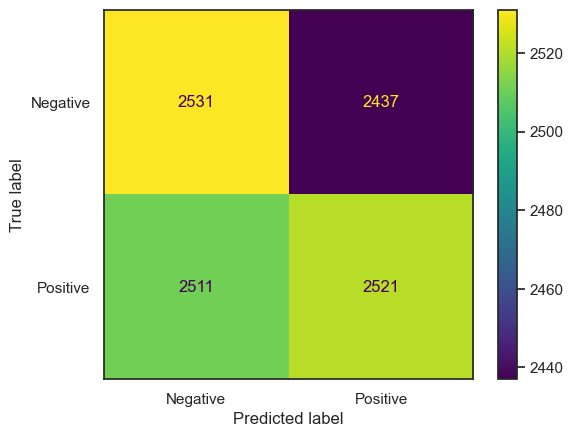

In [30]:
# Evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_hat = model.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_hat)
f1 = f1_score(y_test, y_hat, average='binary')  # use average='macro' or 'weighted' for multiclass
precision = precision_score(y_test, y_hat, average='binary')
recall = recall_score(y_test, y_hat, average='binary')

print("Accuracy: {:.2f}".format(accuracy))
print("F1 Score: {:.2f}".format(f1))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
cm_test = confusion_matrix(y_test, y_hat)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Negative', 'Positive']).plot()
plt.show()


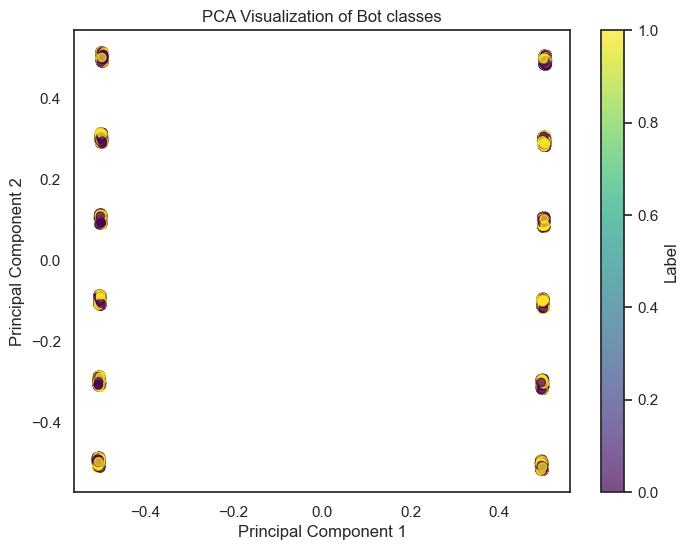

In [31]:
# Inspiration: https://www.datacamp.com/tutorial/introduction-t-sne
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# PCA reduces feature space by finding directions that capture the most variance
pca = PCA(n_components=3, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.title("PCA Visualization of Bot classes")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Label')
plt.show()

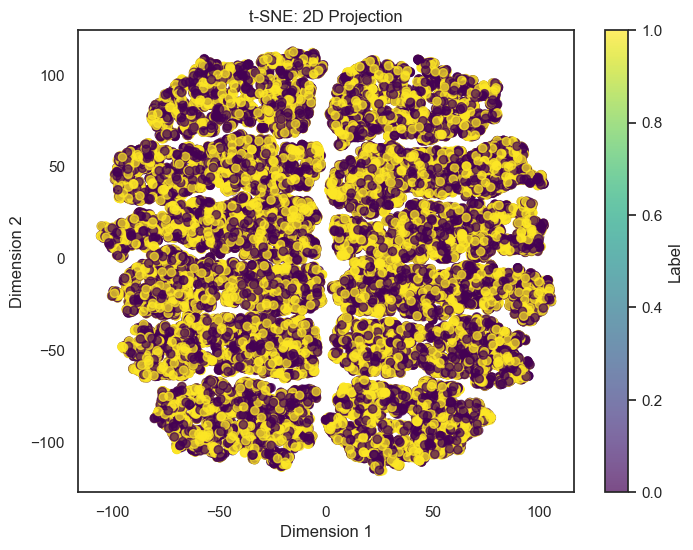

In [32]:
# Interesting, but doesn't preserve local structure very well, let's look at t-SNE
from sklearn.manifold import TSNE
X_tsne = TSNE(n_components=2, random_state=RANDOM_STATE).fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.title("t-SNE: 2D Projection")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(label='Label')
plt.show()

In [33]:
# Try training with the text columns

X = df.drop('Bot Label', axis=1)

print(X.head())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

   Retweet Count  Mention Count  Follower Count  Verified  Location  \
0           0.85            0.2          0.2353       0.0  0.003373   
1           0.55            1.0          0.9617       1.0  0.764465   
2           0.06            0.4          0.4363       1.0  0.257243   
3           0.54            1.0          0.2242       1.0  0.432733   
4           0.26            0.6          0.8438       0.0  0.067188   

   Created At     twt_1     twt_2     twt_3     twt_4  ...  hashtag_91  \
0    0.105605  0.584423 -0.448758  0.221992 -0.083593  ...    0.125355   
1    0.850671  0.603059 -0.539200  0.261076 -0.053392  ...   -0.117175   
2    0.762343  0.602178 -0.544444  0.259417 -0.058034  ...   -0.124059   
3    0.474930  0.629921 -0.661460  0.312158 -0.026327  ...   -0.214849   
4    0.083336  0.631455 -0.702606  0.326289 -0.010229  ...   -0.122647   

   hashtag_92  hashtag_93  hashtag_94  hashtag_95  hashtag_96  hashtag_97  \
0    0.294862    0.243294   -0.232206    0.374747  

In [34]:
# Training
model = svm.SVC(kernel='linear', random_state=RANDOM_STATE)
model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

Accuracy: 0.51
F1 Score: 0.50
Precision: 0.51
Recall: 0.50


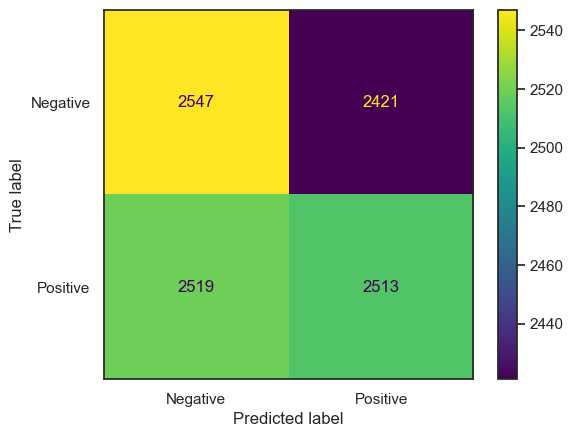

In [35]:
# Evaluation
y_hat = model.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_hat)
f1 = f1_score(y_test, y_hat, average='binary')  # use average='macro' or 'weighted' for multiclass
precision = precision_score(y_test, y_hat, average='binary')
recall = recall_score(y_test, y_hat, average='binary')

print("Accuracy: {:.2f}".format(accuracy))
print("F1 Score: {:.2f}".format(f1))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
cm_test = confusion_matrix(y_test, y_hat)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Negative', 'Positive']).plot()
plt.show()

In [36]:
# We'll try with a Random Forest now
from sklearn.ensemble import RandomForestClassifier

X = df[["Retweet Count", "Mention Count", "Follower Count", "Verified", "Location", "Created At"]]

print(X.head())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

rf_model = RandomForestClassifier(random_state=RANDOM_STATE)

rf_model.fit(X_train, y_train)

   Retweet Count  Mention Count  Follower Count  Verified  Location  \
0           0.85            0.2          0.2353       0.0  0.003373   
1           0.55            1.0          0.9617       1.0  0.764465   
2           0.06            0.4          0.4363       1.0  0.257243   
3           0.54            1.0          0.2242       1.0  0.432733   
4           0.26            0.6          0.8438       0.0  0.067188   

   Created At  
0    0.105605  
1    0.850671  
2    0.762343  
3    0.474930  
4    0.083336  


RandomForestClassifier(random_state=42)

Accuracy: 0.50
F1 Score: 0.49
Precision: 0.51
Recall: 0.48


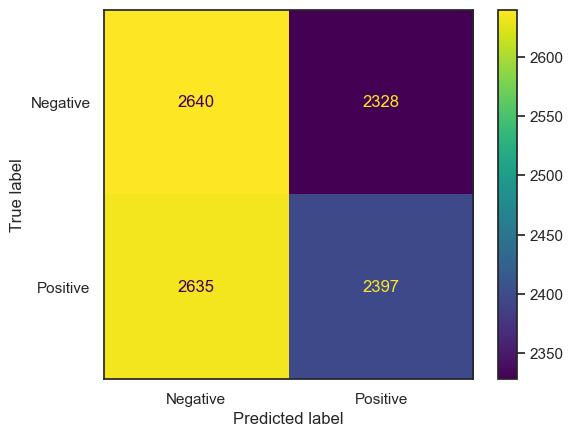

In [37]:
y_hat = rf_model.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_hat)
f1 = f1_score(y_test, y_hat, average='binary')  # use average='macro' or 'weighted' for multiclass
precision = precision_score(y_test, y_hat, average='binary')
recall = recall_score(y_test, y_hat, average='binary')

print("Accuracy: {:.2f}".format(accuracy))
print("F1 Score: {:.2f}".format(f1))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

cm_test = confusion_matrix(y_test, y_hat)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Negative', 'Positive']).plot()
plt.show()

In [38]:
# With text now
X = df.drop('Bot Label', axis=1)

print(X.head())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

rf_model = RandomForestClassifier(random_state=RANDOM_STATE)

rf_model.fit(X_train, y_train)

   Retweet Count  Mention Count  Follower Count  Verified  Location  \
0           0.85            0.2          0.2353       0.0  0.003373   
1           0.55            1.0          0.9617       1.0  0.764465   
2           0.06            0.4          0.4363       1.0  0.257243   
3           0.54            1.0          0.2242       1.0  0.432733   
4           0.26            0.6          0.8438       0.0  0.067188   

   Created At     twt_1     twt_2     twt_3     twt_4  ...  hashtag_91  \
0    0.105605  0.584423 -0.448758  0.221992 -0.083593  ...    0.125355   
1    0.850671  0.603059 -0.539200  0.261076 -0.053392  ...   -0.117175   
2    0.762343  0.602178 -0.544444  0.259417 -0.058034  ...   -0.124059   
3    0.474930  0.629921 -0.661460  0.312158 -0.026327  ...   -0.214849   
4    0.083336  0.631455 -0.702606  0.326289 -0.010229  ...   -0.122647   

   hashtag_92  hashtag_93  hashtag_94  hashtag_95  hashtag_96  hashtag_97  \
0    0.294862    0.243294   -0.232206    0.374747  

RandomForestClassifier(random_state=42)

Accuracy: 0.50
F1 Score: 0.48
Precision: 0.51
Recall: 0.46


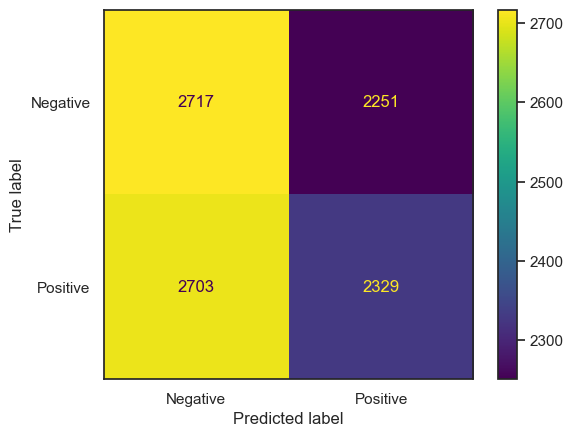

In [39]:
y_hat = rf_model.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_hat)
f1 = f1_score(y_test, y_hat, average='binary')  # use average='macro' or 'weighted' for multiclass
precision = precision_score(y_test, y_hat, average='binary')
recall = recall_score(y_test, y_hat, average='binary')

print("Accuracy: {:.2f}".format(accuracy))
print("F1 Score: {:.2f}".format(f1))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

cm_test = confusion_matrix(y_test, y_hat)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Negative', 'Positive']).plot()
plt.show()

   Retweet Count  Mention Count  Follower Count  Verified  Location  \
0           0.85            0.2          0.2353       0.0  0.003373   
1           0.55            1.0          0.9617       1.0  0.764465   
2           0.06            0.4          0.4363       1.0  0.257243   
3           0.54            1.0          0.2242       1.0  0.432733   
4           0.26            0.6          0.8438       0.0  0.067188   

   Created At  
0    0.105605  
1    0.850671  
2    0.762343  
3    0.474930  
4    0.083336  
Accuracy: 0.50
F1 Score: 0.51
Precision: 0.51
Recall: 0.51


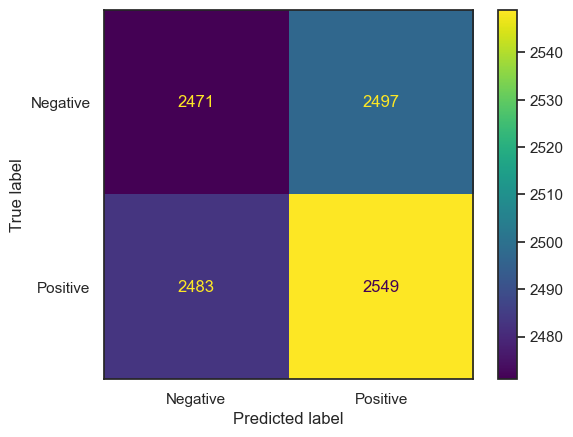

In [40]:
# Decision Tree (without text data)
from sklearn.tree import DecisionTreeClassifier

X = df[["Retweet Count", "Mention Count", "Follower Count", "Verified", "Location", "Created At"]]

print(X.head())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
tree.fit(X_train, y_train)

y_hat = tree.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_hat)
f1 = f1_score(y_test, y_hat, average='binary')  # use average='macro' or 'weighted' for multiclass
precision = precision_score(y_test, y_hat, average='binary')
recall = recall_score(y_test, y_hat, average='binary')

print("Accuracy: {:.2f}".format(accuracy))
print("F1 Score: {:.2f}".format(f1))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

cm_test = confusion_matrix(y_test, y_hat)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Negative', 'Positive']).plot()
plt.show()

   Retweet Count  Mention Count  Follower Count  Verified  Location  \
0           0.85            0.2          0.2353       0.0  0.003373   
1           0.55            1.0          0.9617       1.0  0.764465   
2           0.06            0.4          0.4363       1.0  0.257243   
3           0.54            1.0          0.2242       1.0  0.432733   
4           0.26            0.6          0.8438       0.0  0.067188   

   Created At     twt_1     twt_2     twt_3     twt_4  ...  hashtag_91  \
0    0.105605  0.584423 -0.448758  0.221992 -0.083593  ...    0.125355   
1    0.850671  0.603059 -0.539200  0.261076 -0.053392  ...   -0.117175   
2    0.762343  0.602178 -0.544444  0.259417 -0.058034  ...   -0.124059   
3    0.474930  0.629921 -0.661460  0.312158 -0.026327  ...   -0.214849   
4    0.083336  0.631455 -0.702606  0.326289 -0.010229  ...   -0.122647   

   hashtag_92  hashtag_93  hashtag_94  hashtag_95  hashtag_96  hashtag_97  \
0    0.294862    0.243294   -0.232206    0.374747  

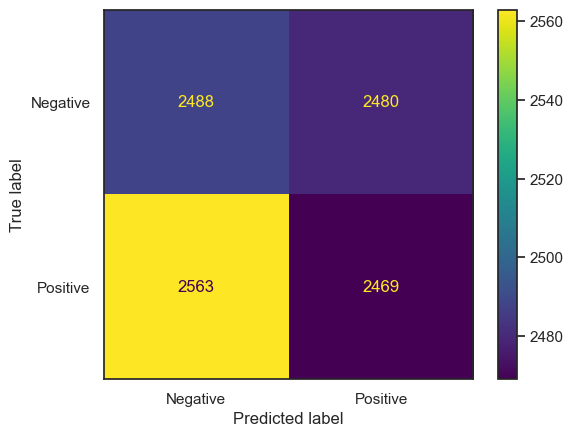

In [41]:
# Decision Tree (with text)
X = df.drop('Bot Label', axis=1)

print(X.head())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
tree.fit(X_train, y_train)

y_hat = tree.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_hat)
f1 = f1_score(y_test, y_hat, average='binary')  # use average='macro' or 'weighted' for multiclass
precision = precision_score(y_test, y_hat, average='binary')
recall = recall_score(y_test, y_hat, average='binary')

print("Accuracy: {:.2f}".format(accuracy))
print("F1 Score: {:.2f}".format(f1))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

cm_test = confusion_matrix(y_test, y_hat)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Negative', 'Positive']).plot()

   Retweet Count  Mention Count  Follower Count  Verified  Location  \
0           0.85            0.2          0.2353       0.0  0.003373   
1           0.55            1.0          0.9617       1.0  0.764465   
2           0.06            0.4          0.4363       1.0  0.257243   
3           0.54            1.0          0.2242       1.0  0.432733   
4           0.26            0.6          0.8438       0.0  0.067188   

   Created At  
0    0.105605  
1    0.850671  
2    0.762343  
3    0.474930  
4    0.083336  
Accuracy: 0.50
F1 Score: 0.46
Precision: 0.51
Recall: 0.42


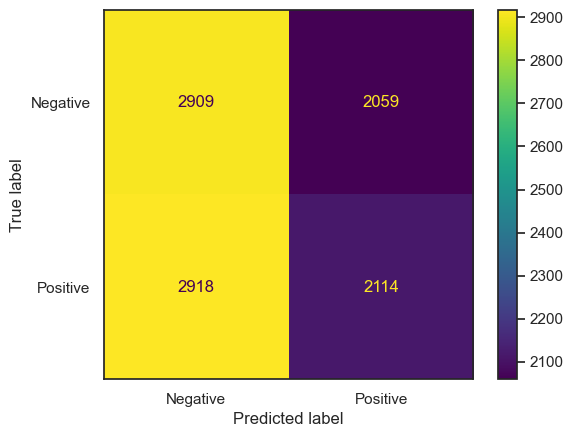

In [42]:
# Naive-Bayes (without text)
from sklearn.naive_bayes import GaussianNB

X = df[["Retweet Count", "Mention Count", "Follower Count", "Verified", "Location", "Created At"]]

print(X.head())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

bayes_model = GaussianNB()
bayes_model.fit(X_train, y_train)

y_hat = bayes_model.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_hat)
f1 = f1_score(y_test, y_hat, average='binary')  # use average='macro' or 'weighted' for multiclass
precision = precision_score(y_test, y_hat, average='binary')
recall = recall_score(y_test, y_hat, average='binary')

print("Accuracy: {:.2f}".format(accuracy))
print("F1 Score: {:.2f}".format(f1))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

cm_test = confusion_matrix(y_test, y_hat)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Negative', 'Positive']).plot()
plt.show()

   Retweet Count  Mention Count  Follower Count  Verified  Location  \
0           0.85            0.2          0.2353       0.0  0.003373   
1           0.55            1.0          0.9617       1.0  0.764465   
2           0.06            0.4          0.4363       1.0  0.257243   
3           0.54            1.0          0.2242       1.0  0.432733   
4           0.26            0.6          0.8438       0.0  0.067188   

   Created At     twt_1     twt_2     twt_3     twt_4  ...  hashtag_91  \
0    0.105605  0.584423 -0.448758  0.221992 -0.083593  ...    0.125355   
1    0.850671  0.603059 -0.539200  0.261076 -0.053392  ...   -0.117175   
2    0.762343  0.602178 -0.544444  0.259417 -0.058034  ...   -0.124059   
3    0.474930  0.629921 -0.661460  0.312158 -0.026327  ...   -0.214849   
4    0.083336  0.631455 -0.702606  0.326289 -0.010229  ...   -0.122647   

   hashtag_92  hashtag_93  hashtag_94  hashtag_95  hashtag_96  hashtag_97  \
0    0.294862    0.243294   -0.232206    0.374747  

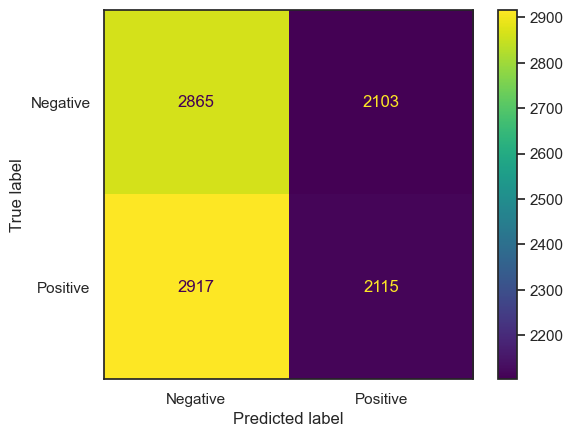

In [43]:
# Naive-Bayes (with text)
X = df.drop('Bot Label', axis=1)

print(X.head())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

bayes_model = GaussianNB()
bayes_model.fit(X_train, y_train)

y_hat = bayes_model.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_hat)
f1 = f1_score(y_test, y_hat, average='binary')  # use average='macro' or 'weighted' for multiclass
precision = precision_score(y_test, y_hat, average='binary')
recall = recall_score(y_test, y_hat, average='binary')

print("Accuracy: {:.2f}".format(accuracy))
print("F1 Score: {:.2f}".format(f1))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

cm_test = confusion_matrix(y_test, y_hat)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Negative', 'Positive']).plot()

   Retweet Count  Mention Count  Follower Count  Verified  Location  \
0           0.85            0.2          0.2353       0.0  0.003373   
1           0.55            1.0          0.9617       1.0  0.764465   
2           0.06            0.4          0.4363       1.0  0.257243   
3           0.54            1.0          0.2242       1.0  0.432733   
4           0.26            0.6          0.8438       0.0  0.067188   

   Created At  
0    0.105605  
1    0.850671  
2    0.762343  
3    0.474930  
4    0.083336  
Accuracy: 0.50
F1 Score: 0.50
Precision: 0.50
Recall: 0.49


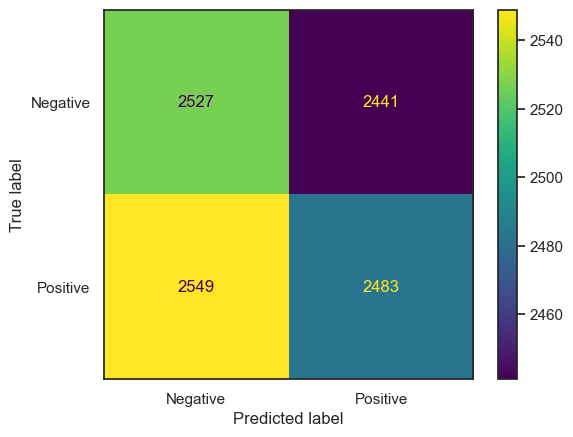

In [44]:
# k-Nearest Neighbors (without text)
from sklearn.neighbors import KNeighborsClassifier

X = df[["Retweet Count", "Mention Count", "Follower Count", "Verified", "Location", "Created At"]]

print(X.head())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_hat = knn.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_hat)
f1 = f1_score(y_test, y_hat, average='binary')  # use average='macro' or 'weighted' for multiclass
precision = precision_score(y_test, y_hat, average='binary')
recall = recall_score(y_test, y_hat, average='binary')

print("Accuracy: {:.2f}".format(accuracy))
print("F1 Score: {:.2f}".format(f1))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

cm_test = confusion_matrix(y_test, y_hat)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Negative', 'Positive']).plot()
plt.show()

   Retweet Count  Mention Count  Follower Count  Verified  Location  \
0           0.85            0.2          0.2353       0.0  0.003373   
1           0.55            1.0          0.9617       1.0  0.764465   
2           0.06            0.4          0.4363       1.0  0.257243   
3           0.54            1.0          0.2242       1.0  0.432733   
4           0.26            0.6          0.8438       0.0  0.067188   

   Created At     twt_1     twt_2     twt_3     twt_4  ...  hashtag_91  \
0    0.105605  0.584423 -0.448758  0.221992 -0.083593  ...    0.125355   
1    0.850671  0.603059 -0.539200  0.261076 -0.053392  ...   -0.117175   
2    0.762343  0.602178 -0.544444  0.259417 -0.058034  ...   -0.124059   
3    0.474930  0.629921 -0.661460  0.312158 -0.026327  ...   -0.214849   
4    0.083336  0.631455 -0.702606  0.326289 -0.010229  ...   -0.122647   

   hashtag_92  hashtag_93  hashtag_94  hashtag_95  hashtag_96  hashtag_97  \
0    0.294862    0.243294   -0.232206    0.374747  

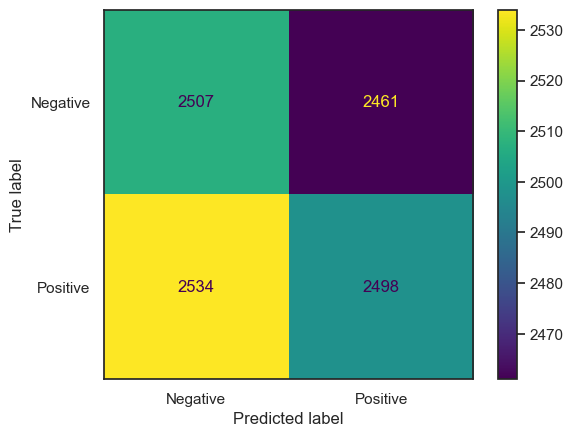

In [45]:
# k-Nearest Neighbors (with text)
X = df.drop('Bot Label', axis=1)

print(X.head())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_hat = knn.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_hat)
f1 = f1_score(y_test, y_hat, average='binary')  # use average='macro' or 'weighted' for multiclass
precision = precision_score(y_test, y_hat, average='binary')
recall = recall_score(y_test, y_hat, average='binary')

print("Accuracy: {:.2f}".format(accuracy))
print("F1 Score: {:.2f}".format(f1))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

cm_test = confusion_matrix(y_test, y_hat)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Negative', 'Positive']).plot()